In [1]:
# package(s) related to time, space and id
import datetime, time
import os
import io
import functools
import logging
import pickle
import random
import math

# package(s) related to the simulation
import enum
import simpy
import scipy as sc
import math
import networkx as nx  
import numpy as np
import pandas as pd
import re
import yaml as yaml
import time
import bisect
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import xarray as xr

from osgeo import gdal
from scipy import interpolate
from scipy.signal import correlate
from shapely.ops import transform
from matplotlib.ticker import MaxNLocator
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# OpenTNSim
from opentnsim import core
from opentnsim import plot
from opentnsim import model
from opentnsim import import_hydrodynamic_dataset
from opentnsim import vessel_traffic_service
from opentnsim import port
from opentnsim import lock
from opentnsim import vessel
from opentnsim import waterway
from opentnsim import output
from opentnsim import tidal_window_constructor
from opentnsim import rule_constructor

# spatial libraries 
import shapely.geometry
import shapely.wkt
import pyproj
import shapely.geometry
import folium
import datetime
import time as timepy

# package(s) for data handling
import requests

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# define the coorinate systemb
geod = pyproj.Geod(ellps="WGS84")

location_vessel_database = "Vessels/richtlijnen-vaarwegen-2017.csv"

In [2]:
def calculate_distance(geometry):
    x = geometry.xy[0]
    y = geometry.xy[1]
    distance = pyproj.Geod(ellps="WGS84").inv(x[0],y[0],x[1],y[1])[2]
    
    return distance

In [3]:
Node = type('Site', (core.Identifiable, core.Log, core.Locatable, core.HasResource), {})
nodes = []
path = []
coords = []

coords.append([0,0]) #node_1
coords.append([0.01,0])#node_2
coords.append([0.02,0])#node_3
coords.append([0.03,0])#node_4
coords.append([0.04,0])#node_5
coords.append([0.05,0])#node_6

for d in range(len(coords)):
    data_node = {"env": [],
                 "name": "Node_" + str(d+1),
                 "geometry": shapely.geometry.Point(coords[d][0], coords[d][1])}
    node = Node(**data_node)
    nodes.append(node)
    
for i in range(len(nodes)-1):
    path.append([nodes[i],nodes[i+1]]) 
    path.append([nodes[i+1],nodes[i]])

FG = nx.DiGraph()

positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

for edge in path:
    geometry = shapely.geometry.LineString([FG.nodes[edge[0].name]['geometry'],FG.nodes[edge[1].name]['geometry']])
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {'geometry': geometry,
                                                                'length': calculate_distance(geometry)},geometry=geometry)

In [4]:
simulation_start = datetime.datetime.now()
duration = 14*24*3600 #seconds
sim = model.Simulation(simulation_start,FG)
env = sim.environment

In [6]:
class RuleConstructor():
    
    def __init__(
        self,
        conditions,
        values,
        operator,
        *args,
        **kwargs):
        
        self.conditions = conditions
        self.values = values
        
        operators = []
        sign_list = operator.split()
        for sign in sign_list:
            if sign[0] != '(' and sign[-1] != ')' and sign != 'x':
                operators.append(sign)
                
        if not operators:
            operators.append(None)
        
        self.operators = operators
        
        return

In [7]:
encounter_restrictions = {('Node_2','Node_3'): RuleConstructor(conditions = [rule_constructor.vessel_characteristics.min_ge_Draught], 
                                                               values = [14], 
                                                               operator = 'x'), 
                          
                          ('Node_3','Node_4'): RuleConstructor(conditions = [rule_constructor.vessel_characteristics.min_ge_Draught], 
                                                               values = [12], 
                                                               operator = 'x'), 
                          
                          ('Node_4','Node_5'): RuleConstructor(conditions = [rule_constructor.vessel_characteristics.min_ge_Draught], 
                                                               values = [14], 
                                                               operator = 'x'),}
overtaking_restrictions = encounter_restrictions

In [8]:
def select_restiction(sections,restrictions):
    restriction = {}
    for section in sections:
        if (section[0],section[1]) in restrictions.keys():
            restriction[section[1]] = restrictions[(section[0],section[1])]
        elif (section[1],section[0]) in restrictions.keys():
            restriction[section[1]] = restrictions[(section[1],section[0])]
        else:
            restriction[section[1]] = None
    return restriction

In [9]:
detector_node_list = [['Node_1'],
                      ['Node_1','Node_6'],
                      ['Node_1','Node_6'],
                      ['Node_1','Node_6'],
                      ['Node_1','Node_6'],
                      ['Node_6']]

In [10]:
junction_nodes = []
for node in FG.nodes:
    if 'Junction' in FG.nodes[node]:
        junction_nodes.append(node)
        
for index,node1 in enumerate(junction_nodes):
    names = []
    sections = []
    for node2 in junction_nodes:
        if node1 == node2:
            continue
            
        route = nx.dijkstra_path(FG, node1, node2)
        section = True
        for node in route[1:-1]:
            if 'Junction' in FG.nodes[node]:
                section = False
                break

        if section:
            sections.append(route)
    
    overtaking_restriction = []
    encounter_restriction = select_restiction(sections,encounter_restrictions)
    #overtaking_restriction = select_restiction(sections,overtaking_restrictions)
    detector_nodes = detector_node_list[index]
    
    #print(node1,sections,encounter_restriction)
    FG.nodes[node1]["Junction"] = waterway.IsWaterwayJunction(env = env, 
                                                              name=node1, 
                                                              sections = sections, 
                                                              encounter_restrictions = encounter_restriction, 
                                                              overtaking_restrictions = overtaking_restriction, 
                                                              detector_nodes = detector_nodes)

In [11]:
Vessel = type('Vessel', 
              (core.SimpyObject,core.Identifiable, port.HasPortAccess, port.HasAnchorage, waterway.HasWaterway, port.HasTurningBasin, port.HasTerminal, core.Movable, core.Routeable, vessel.VesselProperties, vessel.ExtraMetadata), {})

origin = 'Node_1'
destination = 'Node_6'

vessel_input_out = {'name':'LR1',
                    'geometry':FG.nodes[destination]['geometry'],
                    'route':nx.dijkstra_path(FG,destination,origin),
                    'env':env,
                    'type':'Tanker',
                    'B':50,
                    'L':250,
                    'T_f':13,
                    'T_e':9,
                    'H_e':18,
                    'H_f':15,
                    't_b':0.5*3600,
                    't_l':8*3600,
                    't_t':0.5*3600,
                    'ukc':0,
                    'v':5,
                    'max_waiting_time':4*3600,
                    'max_cross_current':0,
                    'delay':0,
                    'priority':False}

vessel_input_in = {'name':'LR1',
                    'geometry':FG.nodes[origin]['geometry'],
                    'route':nx.dijkstra_path(FG,origin,destination),
                    'env':env,
                    'type':'Tanker',
                    'B':50,
                    'L':250,
                    'T_f':13,
                    'T_e':9,
                    'H_e':18,
                    'H_f':15,
                    't_b':0.5*3600,
                    't_l':8*3600,
                    't_t':0.5*3600,
                    'ukc':0,
                    'v':5,
                    'max_waiting_time':4*3600,
                    'max_cross_current':0,
                    'delay':0,
                    'priority':False}

In [12]:
v1 = Vessel(**vessel_input_in)
v1.name = 'v1.1'
sim.add_vessels(origin,destination,v1)

v2 = Vessel(**vessel_input_in)
v2.name = 'v1.2'
v2.metadata['delay'] = 50
sim.add_vessels(origin,destination,v2)

v3 = Vessel(**vessel_input_in)
v3.name = 'v1.3'
v3.metadata['delay'] = 100
sim.add_vessels(origin,destination,v3)

v4 = Vessel(**vessel_input_out)
v4.name = 'v2.1'
sim.add_vessels(destination,origin,v4)

v5 = Vessel(**vessel_input_out)
v5.name = 'v2.2'
v5.metadata['delay'] = 50
sim.add_vessels(destination,origin,v5)

v6 = Vessel(**vessel_input_out)
v6.name = 'v2.3'
v6.metadata['delay'] = 100
sim.add_vessels(destination,origin,v6)

In [13]:
sim.run(duration = duration) # this statement runs the simulation

v1.1 Node_1 Node_2 0
0
v1.1 Node_2 Node_3 0
0
v1.1 Node_3 Node_4 0
0
v1.1 Node_4 Node_5 0
0
v1.1 Node_5 Node_6 0
0
Node_2 1677174197.0
Node_3 1677174419.6389816
Node_4 1677174642.2779632
Node_5 1677174864.9169447
Node_6 1677175087.5559263
0
v2.1 Node_6 Node_5 0
0
v2.1 Node_5 Node_4 0
0
v2.1 Node_4 Node_3 0
one-way v2.1 1677174197.0 v1.1 0 v1.1 1677174642.2779632 445.2779631730944
222.63898158073425
two-way 0 v1.1 1677174642.2779632 1677174864.9169447
222.63898158073425
v2.1 Node_3 Node_2 222.63898158073425
222.63898158073425
v2.1 Node_2 Node_1 222.63898158073425
222.63898158073425
Node_5 1677174419.6389816
Node_4 1677174642.2779632
Node_3 1677174864.9169447
Node_2 1677175087.5559263
Node_1 1677175310.194908
222.63898158073425
v1.2 Node_1 Node_2 0
0
two-way -1 v1.1 1677174197.0 1677174247.0
0.0
v1.2 Node_2 Node_3 0.0
0.0
two-way -1 v1.1 1677174419.6389816 1677174469.6389816
0.0
v1.2 Node_3 Node_4 0.0
one-way v1.2 1677174247.0 v1.1 1 v2.1 1677174864.9169447 445.2779631730944
395.27796316

In [14]:
vessels = sim.environment.vessels #extract vessels (entitie) from environment. It collects info while it moves through the network. That info is stored in the log file. The log file has 
env = sim.environment #extract the environment itself

In [15]:
def calculate_distance(route):
    distance = 0
    for node1,node2 in zip(route[:-1],route[1:]):
        if 'Terminal' in FG.edges[node1,node2].keys():
            p1 = FG.nodes[node1]['geometry']
            p2 = FG.nodes[node1]['geometry']
            distance += vessels[0].wgs84.inv(shapely.geometry.asShape(p1).x,
                                             shapely.geometry.asShape(p1).y,
                                             shapely.geometry.asShape(p2).x,
                                             shapely.geometry.asShape(p2).y,)[2]
        else:
            line = FG.edges[node1,node2]['Info']['geometry']
            x = line.xy[0]
            y = line.xy[1]
            distance += vessels[0].wgs84.inv(x[0],y[0],x[1],y[1])[2]
            
    return distance

vessel_path_x = []
vessel_path_t = []
vessel_waiting = []
starting_node = 'Node_1'
end_node = 'Node_6'
for v in range(0,len(vessels)):
    vessel_path_xt = []
    vessel_path_tt = []
    vessel_waiting_t = []
    distance = 0
    direction = 1
    vessel_path_t0 = simulation_start.timestamp()
    vessel_waiting_t.append(True)
    for t in enumerate(vessels[v].log["Message"]):
        time = vessels[v].log["Timestamp"][t[0]].timestamp()-vessel_path_t0
        not_waiting = True
        
        if t[1].split()[0] == 'Sailing':
            current_node = str(t[1].split()[3])
            next_node = str(t[1].split()[6])

        if 'anchorage' in t[1]:
            if 'Waiting' in t[1]:
                not_waiting = False
            vessel_waiting_t.append(not_waiting)
            vessel_path_xt.append(distance)
            vessel_path_tt.append(time)
            continue
        
        if t[1].split()[0] == 'Sailing':
            if direction == 1:
                if t[1].split()[7] == 'start':
                    route = nx.dijkstra_path(FG,starting_node,current_node)
                elif t[1].split()[7] == 'stop':
                    route = nx.dijkstra_path(FG,starting_node,next_node)
                boolean = 'Terminal' in FG.edges[current_node,next_node].keys()
                distance = calculate_distance(route)
                final_distance = distance
            
            elif direction == -1:
                if t[1].split()[7] == 'start':
                    route = nx.dijkstra_path(FG,starting_node,current_node)
                elif t[1].split()[7] == 'stop':
                    route = nx.dijkstra_path(FG,starting_node,next_node)
                boolean = 'Terminal' in FG.edges[current_node,next_node].keys()
                distance = final_distance - calculate_distance(route)
        
        vessel_path_xt.append(distance)
        vessel_path_tt.append(time)
        vessel_waiting_t.append(not_waiting)
        
    vessel_path_x.append(vessel_path_xt)
    vessel_path_t.append(vessel_path_tt)
    vessel_waiting.append(vessel_waiting_t)

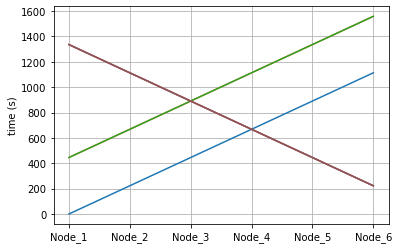

In [16]:
fig,ax = plt.subplots()
for vessel_index,_ in enumerate(vessels):
    ax.plot(vessel_path_x[vessel_index],vessel_path_t[vessel_index])

ax.grid()
total_distance = calculate_distance(nx.dijkstra_path(FG,starting_node,end_node))
ax.set_xticks(np.linspace(0,total_distance,6))
ax.set_xticklabels(list(FG.nodes))
plt.ylabel('time (s)');

In [17]:
pd.set_option('display.max_rows', 500)
vessel = vessels[1]
df = pd.DataFrame.from_dict(vessel.log) #creates a data frame with all the info of vessels[0].
df

,Message,Timestamp,Value,Geometry
0,Sailing from node Node_1 to node Node_2 start,2023-02-23 18:50:42.277963,0,POINT (0 0)
1,Sailing from node Node_1 to node Node_2 stop,2023-02-23 18:54:24.916945,0,POINT (0.01 0)
2,Sailing from node Node_2 to node Node_3 start,2023-02-23 18:54:24.916945,0,POINT (0.01 0)
3,Sailing from node Node_2 to node Node_3 stop,2023-02-23 18:58:07.555926,0,POINT (0.02 0)
4,Sailing from node Node_3 to node Node_4 start,2023-02-23 18:58:07.555926,0,POINT (0.02 0)
5,Sailing from node Node_3 to node Node_4 stop,2023-02-23 19:01:50.194908,0,POINT (0.03 0)
6,Sailing from node Node_4 to node Node_5 start,2023-02-23 19:01:50.194908,0,POINT (0.03 0)
7,Sailing from node Node_4 to node Node_5 stop,2023-02-23 19:05:32.833889,0,POINT (0.04 0)
8,Sailing from node Node_5 to node Node_6 start,2023-02-23 19:05:32.833889,0,POINT (0.04 0)
9,Sailing from node Node_5 to node Node_6 stop,2023-02-23 19:09:15.472871,0,POINT (0.05 0)
